In [1]:
import json
from pathlib import Path
import requests

from math import radians, cos, sin, asin, sqrt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import networkx as nx

from shapely.geometry import shape, Point, LineString
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

In [2]:
# --- Config ---
INPUT_GEOJSON = Path("../data/export.geojson")   # cambia la ruta si está en otra carpeta
CRS_IN        = "EPSG:4326"              # OSM/Overpass suele estar en WGS84
CRS_METERS    = "EPSG:32719"             # UTM 19S (Santiago) para medir en metros
DIST_M        = 200                      # radio de conexión (metros)

NODES_CSV       = Path("../data/grafo_OSM/nodes.csv")
EDGES_CSV       = Path("../data/grafo_OSM/edges.csv")                 # conexiones (i<j)
EDGES_ATTRS_CSV = Path("../data/grafo_OSM/edges_with_attrs.csv")      # opcional: edges + atributos extremos

assert INPUT_GEOJSON.exists(), f"No se encontró {INPUT_GEOJSON.resolve()}"

In [3]:
# --- Utilidades robustas para geometrías OSM con errores (LinearRing<3, etc.) ---
def _rep_point_from_coords(coords):
    arr = np.asarray(coords, dtype=float)
    if arr.ndim == 2 and arr.shape[0] >= 1:
        return Point(float(arr[:,0].mean()), float(arr[:,1].mean()))
    return None

def _safe_geom(geomdict):
    if geomdict is None:
        return None
    gtype = geomdict.get("type")
    try:
        return shape(geomdict)  # si la geometría es válida
    except Exception:
        try:
            if gtype == "Polygon":
                ring = (geomdict.get("coordinates", [[]])[0]) if geomdict.get("coordinates") else []
                return _rep_point_from_coords(ring)
            if gtype == "MultiPolygon":
                # tomar punto representativo de cada polígono; nos quedamos con el primero válido
                for poly in geomdict.get("coordinates", []):
                    ring = poly[0] if len(poly)>0 else []
                    pt = _rep_point_from_coords(ring)
                    if pt is not None:
                        return pt
                return None
            if gtype == "LineString":
                return _rep_point_from_coords(geomdict.get("coordinates", []))
            if gtype == "MultiLineString":
                coords = []
                for ls in geomdict.get("coordinates", []):
                    coords += ls
                return _rep_point_from_coords(coords)
            if gtype == "Point":
                c = geomdict.get("coordinates", None)
                return Point(c[0], c[1]) if c is not None else None
            if gtype == "MultiPoint":
                return _rep_point_from_coords(geomdict.get("coordinates", []))
            if gtype == "GeometryCollection":
                for p in geomdict.get("geometries", []):
                    pg = _safe_geom(p)
                    if isinstance(pg, Point):
                        return pg
                return None
        except Exception:
            return None
    return None

In [4]:

# --- Cargar GeoJSON crudo y convertir TODO a puntos + props ---
data = json.loads(INPUT_GEOJSON.read_text(encoding="utf-8"))
features = data.get("features", [])
records = []
for ftr in features:
    props = ftr.get("properties", {}) or {}
    g = _safe_geom(ftr.get("geometry", None))
    if g is None:
        continue
    if not isinstance(g, Point):
        g = g.representative_point()
    records.append({"geometry": g, **props})

gdf = gpd.GeoDataFrame(records, geometry="geometry", crs=CRS_IN).reset_index(drop=True)
gdf["node_id"] = gdf.index
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y

# --- Elegir columnas informativas típicas de OSM (si existen) ---
candidate_cols = [
    "name","amenity","shop","office","building",
    "addr:city","addr:suburb","addr:district","addr:municipality","is_in:municipality",
    "addr:county","addr:province","addr:state","addr:postcode","addr:street"
]
keep_cols = ["node_id","lat","lon"] + [c for c in candidate_cols if c in gdf.columns]
nodes_df = gdf[keep_cols].copy()
nodes_df.to_csv(NODES_CSV, index=False)
print(f"✔️ nodes.csv guardado en {NODES_CSV.resolve()} (filas={len(nodes_df)})")

# --- Construir edges (pares <= DIST_M) con KDTree en CRS métrico ---
gdf_m = gdf.to_crs(CRS_METERS)
coords = np.c_[gdf_m.geometry.x.values, gdf_m.geometry.y.values]
tree = cKDTree(coords)
neighbors = tree.query_ball_tree(tree, r=DIST_M)

edges = set()
for i, neigh in enumerate(neighbors):
    for j in neigh:
        if i < j:  # i<j evita duplicados y self-loops
            edges.add((i, j))
edges_df = pd.DataFrame(sorted(edges), columns=["Nodo_A_ID","Nodo_B_ID"])
edges_df.to_csv(EDGES_CSV, index=False)
print(f"✔️ edges.csv guardado en {EDGES_CSV.resolve()} (aristas={len(edges_df)})")

# --- (Opcional) edges_with_attrs: mezcla edges + atributos extremos A/B ---
nodes_A = nodes_df.add_suffix("_A").rename(columns={"node_id_A":"Nodo_A_ID"})
nodes_B = nodes_df.add_suffix("_B").rename(columns={"node_id_B":"Nodo_B_ID"})
edges_attrs = edges_df.merge(nodes_A, on="Nodo_A_ID", how="left").merge(nodes_B, on="Nodo_B_ID", how="left")
edges_attrs.to_csv(EDGES_ATTRS_CSV, index=False)
print(f"✔️ edges_with_attrs.csv guardado en {EDGES_ATTRS_CSV.resolve()} (aristas={len(edges_attrs)})")

✔️ nodes.csv guardado en /Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/data/grafo_OSM/nodes.csv (filas=26787)
✔️ edges.csv guardado en /Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/data/grafo_OSM/edges.csv (aristas=287035)
✔️ edges_with_attrs.csv guardado en /Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/data/grafo_OSM/edges_with_attrs.csv (aristas=287035)


In [5]:
df_conexiones = pd.read_csv('../data/grafo_OSM/edges_with_attrs.csv', low_memory=False)
df_nodos = pd.read_csv('../data/grafo_OSM/nodes.csv', low_memory=False)
df_aristas = pd.read_csv('../data/grafo_OSM/edges.csv', low_memory=False)

In [6]:
g_nodes = gpd.GeoDataFrame(df_nodos.copy(), geometry=gpd.points_from_xy(df_nodos["lon"], df_nodos["lat"]), crs="EPSG:4326")
id2pt = dict(zip(g_nodes["node_id"], g_nodes.geometry))
edges = df_aristas.copy()

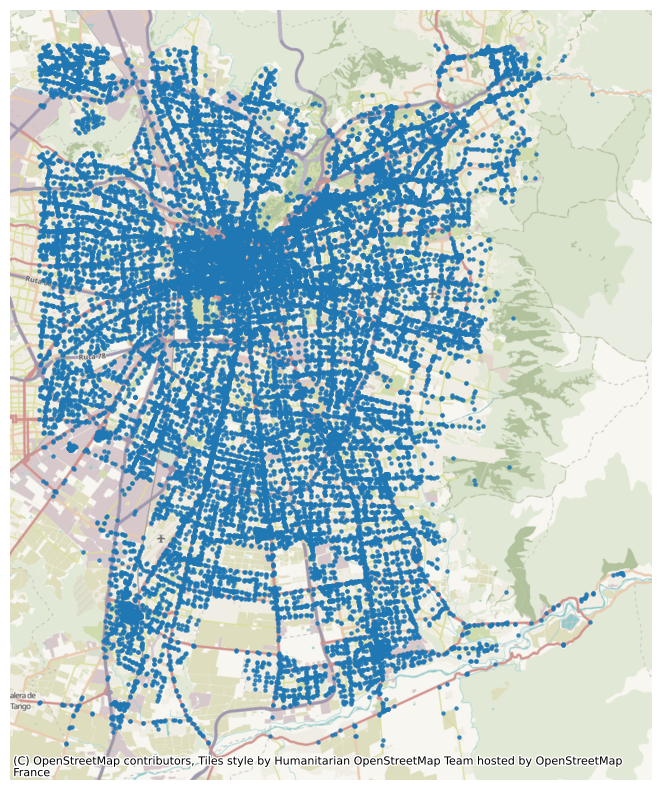

In [7]:
def build_line(row):
    a = row["Nodo_A_ID"]
    b = row["Nodo_B_ID"]
    if a in id2pt and b in id2pt:
        return LineString([id2pt[a], id2pt[b]])
    return None

edges["geometry"] = edges.apply(build_line, axis=1)

g_edges = gpd.GeoDataFrame(
    edges.dropna(subset=["geometry"]).copy(),
    geometry="geometry",
    crs="EPSG:4326"
)

# 4) (Opcional) Proyectar a Web Mercator para agregar fondo de mapa (tiles)
try:
    import contextily as cx
    g_nodes_3857 = g_nodes.to_crs(3857)
    g_edges_3857 = g_edges.to_crs(3857)
    ax = g_edges_3857.plot(figsize=(10,10), linewidth=0.5, alpha=0.6)
    g_nodes_3857.plot(ax=ax, markersize=5, alpha=0.8)
    cx.add_basemap(ax, crs=g_nodes_3857.crs)  # fondo tipo “mapita”
    ax.set_axis_off()

except Exception as e:
    # Sin contextily o sin internet: ploteo simple en WGS84
    ax = g_edges.plot(figsize=(10,10), linewidth=0.5, alpha=0.6)
    g_nodes.plot(ax=ax, markersize=5, alpha=0.8)
    ax.set_axis_off()

In [8]:
min_lon, min_lat = -70.95, -33.65
max_lon, max_lat = -70.445, -33.325

overpass_query = f"""
[out:json][timeout:180][bbox:{min_lat},{min_lon},{max_lat},{max_lon}];
(
  node["amenity"="school"];
  node["amenity"="university"];
  node["amenity"="college"];
  node["amenity"="kindergarten"];
  node["shop"];
  node["amenity"="restaurant"];
  node["amenity"="cafe"];
  node["amenity"="bank"];
  node["amenity"="pharmacy"];
  node["amenity"="hospital"];
  node["amenity"="clinic"];
  node["amenity"="doctors"];
  node["public_transport"="stop_position"];
  node["highway"="bus_stop"];
  node["leisure"="park"];
  node["leisure"="playground"];
  node["amenity"="police"];
  node["amenity"="fire_station"];
  node["amenity"="library"];
);

out body;
"""

In [9]:
# Función para obtener datos de Overpass API
def get_overpass_data(query):
    """
    Consulta la API de Overpass y retorna los datos en formato JSON
    """
    overpass_url = "http://overpass-api.de/api/interpreter"
    response = requests.post(overpass_url, data={'data': query})
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error en la consulta: {response.status_code}")

# Función para clasificar el tipo de nodo
def classify_node(tags):
    """
    Clasifica un nodo según sus tags de OSM
    """
    if 'amenity' in tags:
        amenity = tags['amenity']
        if amenity in ['school', 'university', 'college', 'kindergarten']:
            return 'educacion'
        elif amenity in ['restaurant', 'cafe']:
            return 'gastronomia'
        elif amenity in ['hospital', 'clinic', 'doctors']:
            return 'salud'
        elif amenity in ['bank', 'pharmacy']:
            return 'servicios'
        elif amenity in ['police', 'fire_station']:
            return 'seguridad'
        elif amenity == 'library':
            return 'cultura'
    
    if 'shop' in tags:
        return 'comercio'
    
    if 'public_transport' in tags or 'highway' in tags:
        return 'transporte'
    
    if 'leisure' in tags:
        return 'recreacion'
    
    return 'otro'

In [10]:
print("Obteniendo datos de Overpass API...")
data = get_overpass_data(overpass_query)

# Procesar los nodos
nodes_data = []
for element in data['elements']:
    if element['type'] == 'node':
        node_info = {
            'id': element['id'],
            'lat': element['lat'],
            'lon': element['lon'],
            'tipo': classify_node(element.get('tags', {})),
            'nombre': element.get('tags', {}).get('name', 'Sin nombre'),
            'tags': element.get('tags', {})
        }
        nodes_data.append(node_info)

print(f"Total de nodos obtenidos: {len(nodes_data)}")

# Crear DataFrame
df_nodes = pd.DataFrame(nodes_data)
g_nodes = gpd.GeoDataFrame(df_nodes.copy(), geometry=gpd.points_from_xy(df_nodes["lon"], df_nodes["lat"]), crs="EPSG:4326")
g_nodes_m = g_nodes.to_crs("EPSG:32719")
coords = np.c_[g_nodes_m.geometry.x.values, g_nodes_m.geometry.y.values]
tree = cKDTree(coords)

print("\nDistribución de tipos de nodos:")
print(df_nodes['tipo'].value_counts())
print("\nCalculando conexiones (esto puede tomar un tiempo)...")


MAX_DISTANCE = 200  # metros
neighbors = tree.query_ball_tree(tree, r=MAX_DISTANCE)

edges_list = []
for i, neigh_list in enumerate(neighbors):
    for j in neigh_list:
        if i < j:
            id_i = g_nodes.iloc[i]["id"]
            id_j = g_nodes.iloc[j]["id"]
            edges_list.append((id_i, id_j))

# Construir grafo
G = nx.Graph()
for _, node in df_nodes.iterrows():
    G.add_node(node['id'], 
               lat=node['lat'], 
               lon=node['lon'], 
               tipo=node['tipo'],
               nombre=node['nombre'])
G.add_edges_from(edges_list)

# 4. Construir edges sin doble for N²
edges = []
for i, neigh_list in enumerate(neighbors):
    for j in neigh_list:
        if i < j:
            edges.append((g_nodes.iloc[i]["id"], g_nodes.iloc[j]["id"]))

Obteniendo datos de Overpass API...
Total de nodos obtenidos: 30171

Distribución de tipos de nodos:
tipo
transporte     12244
comercio        9740
gastronomia     2941
educacion       2376
servicios       1393
recreacion      1025
salud            290
seguridad         95
cultura           67
Name: count, dtype: int64

Calculando conexiones (esto puede tomar un tiempo)...


In [11]:
# Estadísticas del grafo
print("\n=== ESTADÍSTICAS DEL GRAFO ===")
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")
print(f"Densidad del grafo: {nx.density(G):.6f}")
print(f"¿Es conexo?: {nx.is_connected(G)}")
if not nx.is_connected(G):
    componentes = list(nx.connected_components(G))
    print(f"Número de componentes conexas: {len(componentes)}")
    print(f"Tamaño de la componente más grande: {len(max(componentes, key=len))}")

# Guardar datos
print("\nGuardando datos...")
df_nodes.to_csv('nodos_santiago.csv', index=False)
nx.write_gexf(G, '../data/grafo_OSM/grafo_santiago.gexf')
print("Datos guardados: 'nodos_santiago.csv' y 'grafo_santiago.gexf'")


=== ESTADÍSTICAS DEL GRAFO ===
Número de nodos: 30171
Número de aristas: 304498
Densidad del grafo: 0.000669
¿Es conexo?: False
Número de componentes conexas: 1731
Tamaño de la componente más grande: 14458

Guardando datos...
Datos guardados: 'nodos_santiago.csv' y 'grafo_santiago.gexf'



Generando visualización...
Grafo guardado como 'grafo_santiago_urbano.png'


<Figure size 640x480 with 0 Axes>

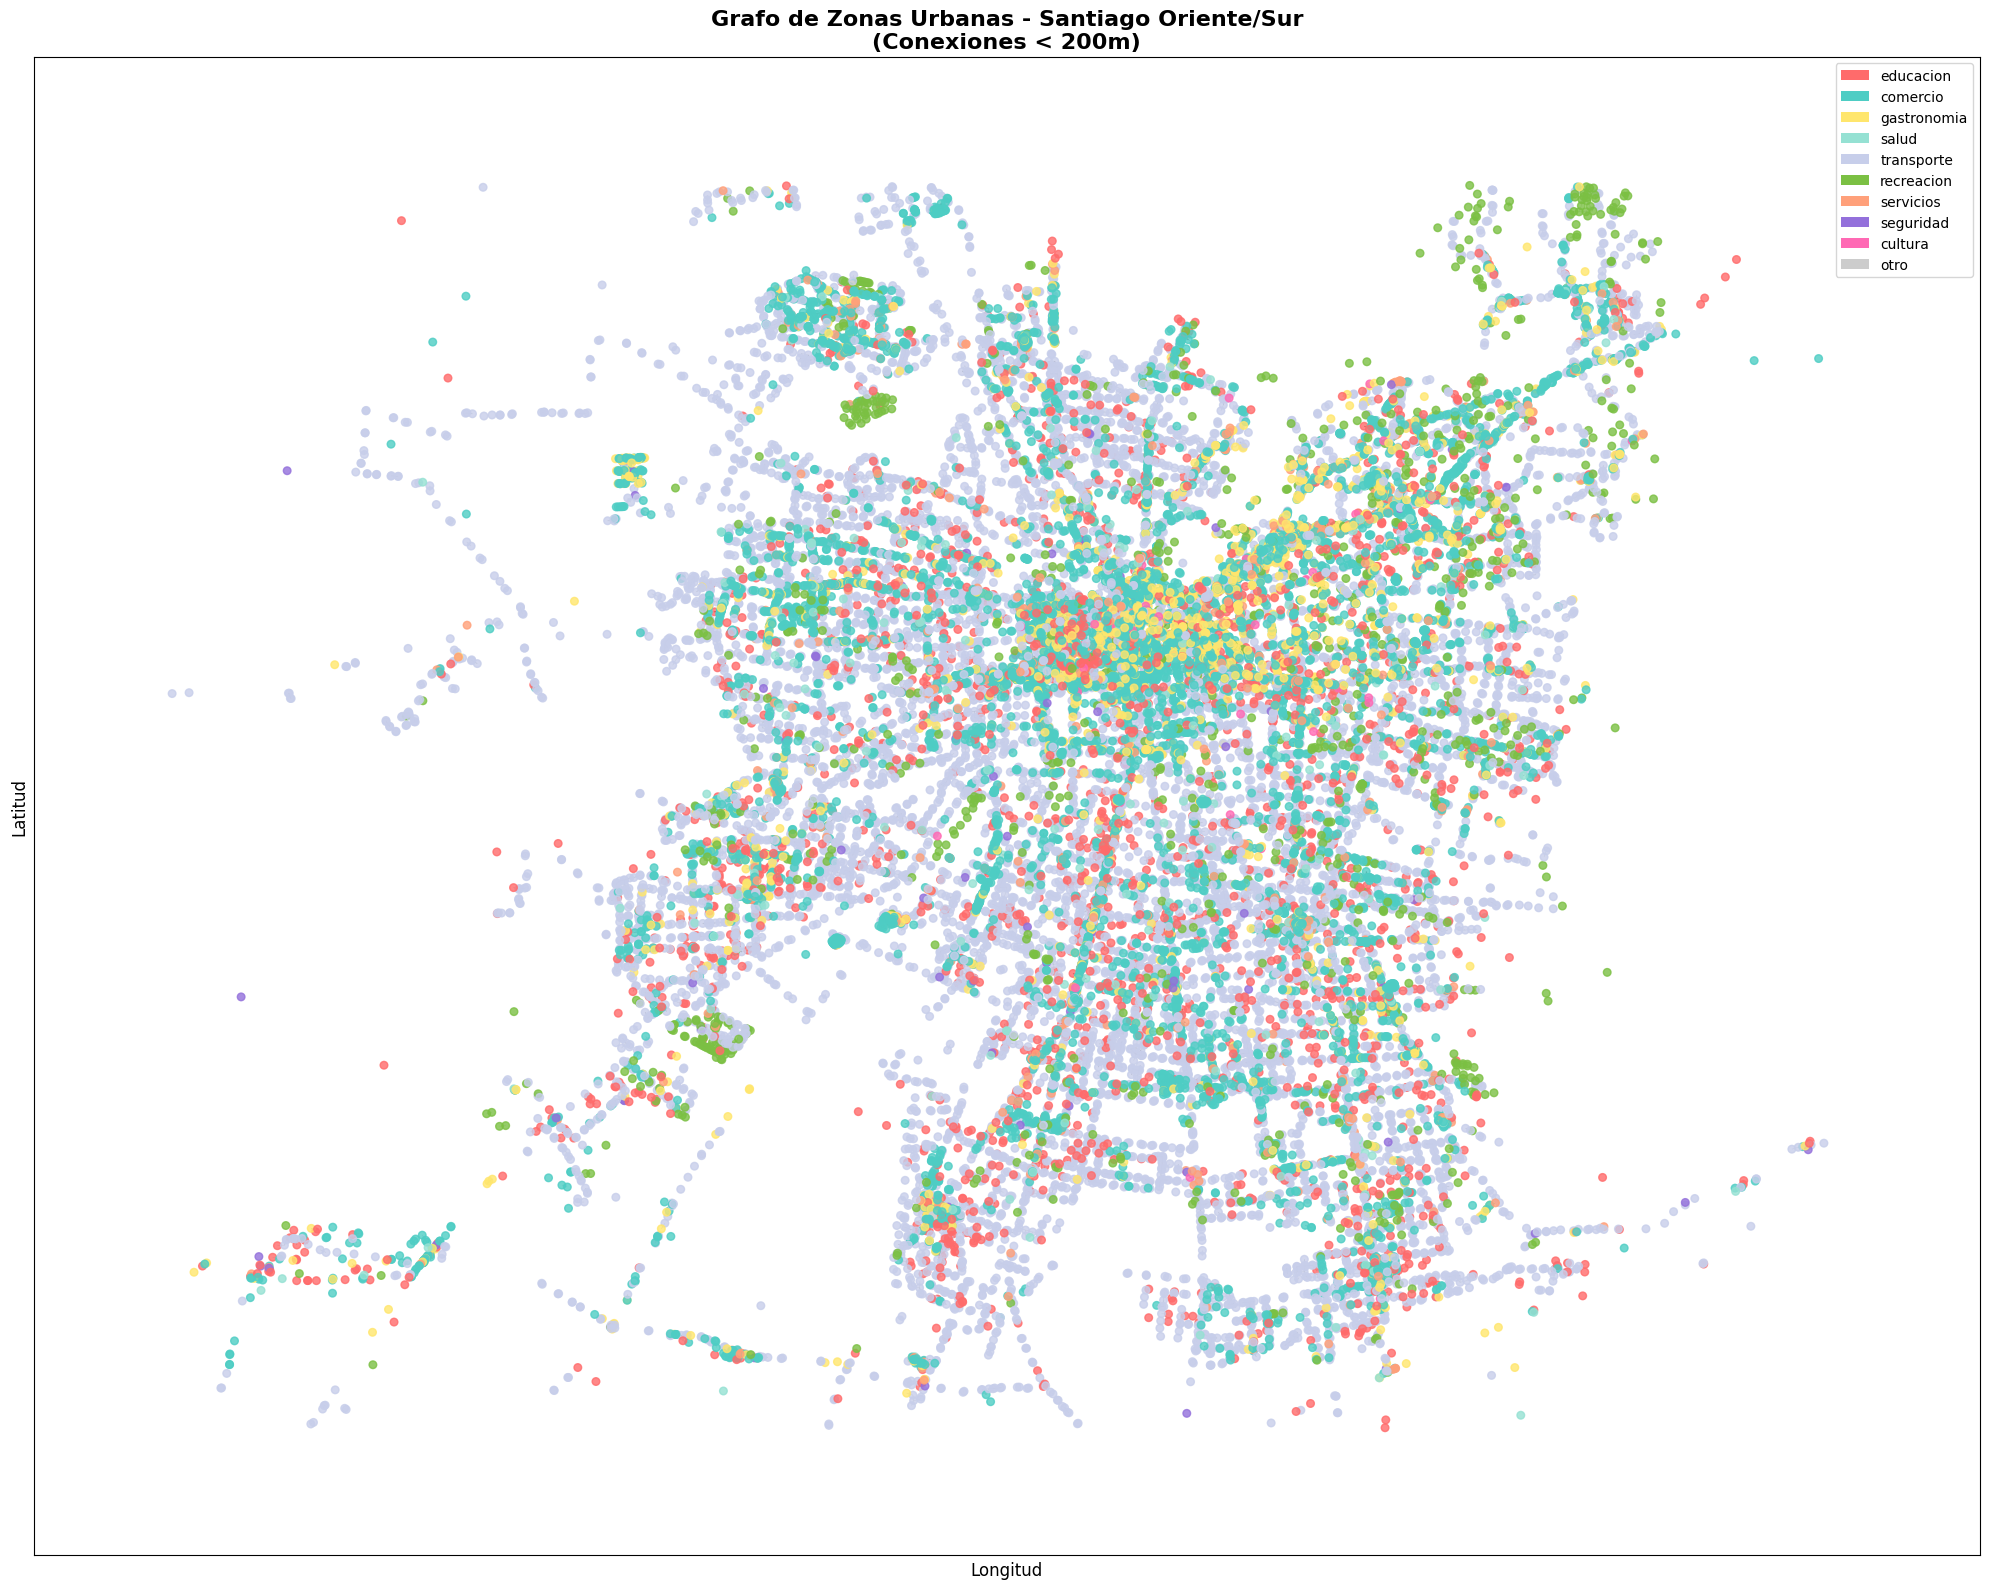

In [12]:
# Visualizar el grafo
print("\nGenerando visualización...")

# Colores para cada tipo de nodo
color_map = {
    'educacion': '#FF6B6B',
    'comercio': '#4ECDC4',
    'gastronomia': '#FFE66D',
    'salud': '#95E1D3',
    'transporte': '#C7CEEA',
    'recreacion': '#7BC043',
    'servicios': '#FFA07A',
    'seguridad': '#9370DB',
    'cultura': '#FF69B4',
    'otro': '#CCCCCC'
}

node_colors = [color_map.get(G.nodes[node]['tipo'], '#CCCCCC') for node in G.nodes()]

# Usar posiciones geográficas reales
pos = {node: (G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes()}
plt.savefig('../figs/grafo_santiago_urbano.png', dpi=300, bbox_inches='tight')
print("Grafo guardado como 'grafo_santiago_urbano.png'")


plt.figure(figsize=(20, 16))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

# Crear leyenda
legend_elements = [Patch(facecolor=color, label=tipo) 
                   for tipo, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.title(f'Grafo de Zonas Urbanas - Santiago Oriente/Sur\n(Conexiones < {MAX_DISTANCE}m)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.tight_layout()

plt.show()

In [13]:
# Análisis adicional
print("\n=== ANÁLISIS DE CENTRALIDAD ===")
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 nodos más conectados:")
for node_id, centrality in top_nodes:
    node_data = G.nodes[node_id]
    print(f"- {node_data['nombre'][:40]} ({node_data['tipo']}): {centrality:.4f}")


=== ANÁLISIS DE CENTRALIDAD ===

Top 10 nodos más conectados:
- Biblioteca Conventual "Toma y Lee" (cultura): 0.0058
- PC Factory (comercio): 0.0056
- Banco Santander (servicios): 0.0055
- Rotter Krauss (comercio): 0.0055
- Bottero (comercio): 0.0055
- Biblioteca P. Alfonso Escudero (cultura): 0.0055
- Doite (comercio): 0.0055
- SalcoBrand (servicios): 0.0054
- Optica Santa Lucia (comercio): 0.0054
- Cruz Verde (servicios): 0.0054
